## Preference-Based Recommendation System for Groups

Algorithmic Marketing Class Project

Name: Li Liu, Suresh Govindaraj, Xi Zhao

Date: March 2020

A group of people went to have an amazing restaurant dining experience in Las Vegas. Some of them were attracted by a French restaurant 30 min away. Some of them thought the nearby sushi place was good enough. They opened Yelp and set the filters. But it didn't help them decide because the app showed each of them very different results.

Here comes our system. We want to help them decide which ones work best for them all.

Using our utility maximization framework, our system recommends the restaurants that will most likely maximize their total utilities.

Suppose we have three people: A, B, C are choosing from N restaurants (R indicates restaurants factors).

For each restaurant i (i=1...N), each person would have a utility for i: $u_A(R_i)$, $u_B(R_i)$, $u_C(R_i)$

We need to have a match function for predicting the total utilities from eating at this restaurant, such that $m_{R_i}(A,B,C) = U_{i}(u(R_i), R_i, Weights, Preferences)$

Our core algorithm will account for the following factors:

* Each restaurant has a baseline utility for the group (Think of $\beta_0$). We use machine learning to predict this utility by using the existing _**Yelp reviews data**_.

Then we will use _**users' input data**_ to adjust the baseline utility based on the groups' preferences and consensus ($\sum_k(\prod_m(p_m*w_m)X_k)$): 

* People have different voting weights (Ex. parents make the final decision instead of kids)

* People have own preferences (Ex. not important at all, neutral, very important)

* People care about others. The total utility depends on others' preference. If A knows B and C hate pizza, the utility for A to choose a pizza place will be lower than the case if A dining alone. 

When A, B, C open the system, they will be asked to choose their preferences for distance and cuisine types. If the factor is not important for A at all, the $p_{A}=0.1$. If the factor is neutral for A, the $p_{A}=0.5$. If the factor is very important for A, the $p_{A}=1$. Also, they have different voting weights w, $w_A, w_b, w_C$, and $w_A+w_b+w_C=1$, 

Generally, suppose we have M (m=1...M) people to choose from N (i=1...N) restaurants and the system asks them to answer K (k=1...K)questions:

$$U_{i} = \beta_0 + \beta_1X_1+ \beta_2X_2+...+\beta_kX_k+\epsilon$$
$$\hat{U_{i}}= \hat{f}(Restaurant Reputations, Weekend, Group...) + \sum_k(\prod_m(p_m*w_m)X_k)$$

Then we have scores for all restaurants from i=1 to N. We can sort them and recommend the top ones for the group.

#### Import packages

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import six
import statsmodels.api as sm
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
sns.set_style("white")
plt.style.use('seaborn-deep')

start=time.time()

#### Read in data

In [143]:
# review 
rev = pd.read_csv("yelp_review.csv")
print("total review text", rev.shape)
rev.head(2)

total review text (5261668, 9)


,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0


#### Subset the data 

1. Only restaurants in Las Vegas

2. Join data from business and users

In [144]:
# business
bus = pd.read_csv("yelp_business.csv")
print("total business",bus.shape)

# select restaurants in LV
LV = bus[bus["city"] == "Las Vegas"]
LVR = LV[LV['categories'].str.contains('Restaurants') == True] 

# select only open restaurants; drop uninformative features
LVR = LVR[LVR["is_open"]==1]
LVR = LVR.drop(["city", "state", "postal_code"], axis=1)

print("total open restaurants", LVR.shape)

total business (174567, 13)
total open restaurants (3990, 10)


In [54]:
# user data
user = pd.read_csv("yelp_user.csv")
user.shape

(1326100, 22)

In [55]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'useful',
       'funny', 'cool', 'fans', 'elite', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

##### Aggregate data 
Each line represents a review for a restaurant by one user

In [56]:
agg = pd.merge(LVR, rev, how="left", on="business_id")
agg = pd.merge(agg, user, how="left", on="user_id")
agg.rename(columns = {'stars_x':"star_bus", "review_count_x": "cts_bus",
                      "stars_y": "star_customer"},
           inplace = True)
agg.shape

(795588, 39)

##### Only keep the most relevant reviews

Restaurants normally update and improve products and services constantly to satisfy customers' needs, especially at Las Vegas. We will only keep the reviews in the last two years.

In [57]:
agg["DATE"] = pd.to_datetime(agg["date"], format = '%Y/%m/%d')
agg["date_yr"] = agg["DATE"].dt.year
agg["date_mt"] = agg["DATE"].dt.month

In [58]:
agg["DATE"].describe()

count                  795588
unique                   4317
top       2017-08-12 00:00:00
freq                      766
first     2005-01-26 00:00:00
last      2017-12-11 00:00:00
Name: DATE, dtype: object

In [145]:
agg = agg[agg["date_yr"]>=2016]
agg.shape

(344012, 51)

In [146]:
# skim data
agg.head(5)

,business_id,name_x,neighborhood,address,latitude,longitude,star_bus,cts_bus,is_open,categories,...,date_mt,y2,normy,y,quarter,rate,y2_new,star_bus_new,guess,dayofweek
0,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,1,Nightlife;Bars;Barbeque;Sports Bars;American (...,...,3,4.333333,0.299161,55.059464,8,1.025495,4.225601,3.900554,female,0
1,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,1,Nightlife;Bars;Barbeque;Sports Bars;American (...,...,8,5.362398,0.897184,68.781015,6,1.019061,5.262096,3.925182,male,5
2,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,1,Nightlife;Bars;Barbeque;Sports Bars;American (...,...,1,0.250000,-2.073795,0.612276,4,1.012667,0.246873,3.949964,female,5
3,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,1,Nightlife;Bars;Barbeque;Sports Bars;American (...,...,8,1.500000,-1.347380,17.279782,6,1.019061,1.471943,3.925182,male,0
5,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,1,Nightlife;Bars;Barbeque;Sports Bars;American (...,...,10,4.101928,0.164684,51.973909,7,1.022273,4.012556,3.912849,unknown,5


In [61]:
# current columns
agg.columns

Index(['business_id', 'name_x', 'neighborhood', 'address', 'latitude',
       'longitude', 'star_bus', 'cts_bus', 'is_open', 'categories',
       'review_id', 'user_id', 'star_customer', 'date', 'text', 'useful_x',
       'funny_x', 'cool_x', 'name_y', 'review_count_y', 'yelping_since',
       'friends', 'useful_y', 'funny_y', 'cool_y', 'fans', 'elite',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos', 'DATE',
       'date_yr', 'date_mt'],
      dtype='object')

In [62]:
#Subset the data to speed up execution
#sample = 10000
#agg = agg.iloc[:sample]

### Predicted utility: (rescaled) customers ratings

y is the measure for customer satisfaction. We reweighed and rescaled the star ratings.

In [147]:
# individual ratings for particular restaurants are positive correlated with their average ratings for all reviews
np.corrcoef(agg['average_stars'],  agg["star_customer"])[0,1]

0.5357548482299939

Text(0.5, 0.98, 'Hexbin plot of Customer Current and Previous Ratings')

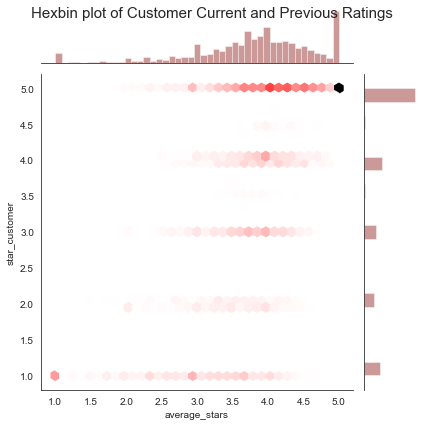

In [148]:
# Hexbin plot
agguser = agg[:10000].groupby('user_id')[['star_customer', 'average_stars']].mean()

sns.jointplot(agguser['average_stars'], agguser["star_customer"], 
              kind='hex', color='maroon')

plt.suptitle("Hexbin plot of Customer Current and Previous Ratings", fontsize=15)
#plt.savefig('HexbinPlot of Customer Current and Previous Ratings .png')

In [149]:
agg[['average_stars',"star_customer"]].head(5)

,average_stars,star_customer
0,3.00,4
1,3.67,5
2,4.00,1
3,4.00,2
5,3.63,4


##### Potential issue

Customers have different rating standards. So a rating of 3 could mean different satisfaction by two customoers, if one has average ratings of 5 (implying dissatisfaction) and the other has average rating of 1 (implying satisfaction). I solve this by reweighting the individual ratings by their average ratings.

In [66]:
# reweighed and rescaled consumer satisfaction measure

# a. Account for the "extra" part deviated from the average ratings
agg['y2'] = agg['star_customer'] + (agg['star_customer']-agg['average_stars'])/agg['average_stars']

# b. Normalization
agg['normy'] = (agg['y2'] - np.mean(agg['y2']))/np.std(agg['y2'])

# c. Rescale to 0-100 
agg['y'] = ((100 - 0) / (max(agg['normy'] ) - min(agg['normy'] ))) * (agg['normy'] - min(agg['normy'])) + 0 

##### Test cases

In [67]:
# case when relative rating is high
agg[['average_stars',"star_customer", "y2", "normy", "y"]][agg['y']==100]

,average_stars,star_customer,y2,normy,y
760832,1.35,5,7.703704,2.257792,100.0


In [68]:
# case when relative rating is low
agg[['average_stars',"star_customer", "y2", "normy", "y"]][agg['y']==0]

,average_stars,star_customer,y2,normy,y
588474,4.9,1,0.204082,-2.10048,0.0


##### Summary statistics

In [69]:
# statistics of original scores and transformed scores
agg[['star_customer','y']].describe()

,star_customer,y
count,482617.000000,482617.000000
mean,3.812118,48.195251
std,1.414832,22.944898
min,1.000000,0.000000
25%,3.000000,34.310001
50%,4.000000,52.876118
75%,5.000000,66.488611
max,5.000000,100.000000


In [70]:
# Since median>mean, y is left skewed
np.median(agg['y'])

52.87611793038332

In [71]:
# abbreviation

# Y is the categorical star rating
Y = agg["star_customer"]
# y is the reweighted numerical grade with 0-100 scale
y = agg['y']

Text(0.5, 0.98, 'Histogram of the Consumer Satisfaction Score')

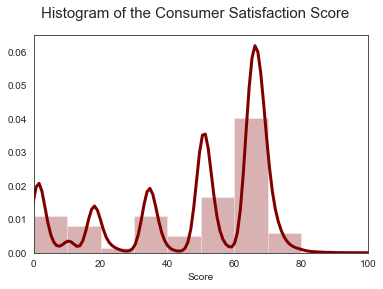

In [72]:
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':3})

sns.distplot(y, bins=10, color="maroon", label="score", **kwargs)
plt.xlim(0,100)
plt.xlabel("Score")
plt.suptitle("Histogram of the Consumer Satisfaction Score", fontsize=15)
#plt.savefig("Histogram of the Consumer Satisfaction Score.png")

Text(0.5, 1.0, 'Pie Chart of Stars Ratios')

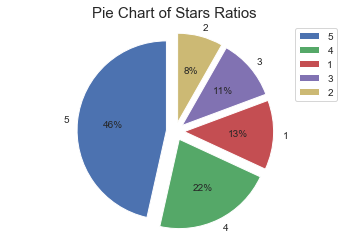

In [73]:
#5    330703
#4    202367
#3    103878
#1     88280
#2     70360

labels = Y.value_counts().index
fig1, ax1 = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
ax1.pie(Y.value_counts(),  explode = explode, labels = Y.value_counts().index,
         autopct='%1.0f%%', startangle = 90)
ax1.axis('equal') 
plt.legend()
plt.title("Pie Chart of Stars Ratios", fontsize = 15)
#plt.savefig("Pie Chart of Stars Ratios")

### Independent variables

##### Restaurants Current Total Stars and Review Counts (Prior info for consumers)

In [101]:
X = agg[['cts_bus', 'star_bus', 'y2']]

In [95]:
# create quarter index
def quarter(df):
    
    ind = (df["date_yr"]-2015)*4
    
    if df["date_mt"]>=1 and df["date_mt"]<=3:
        return ind+0
    elif df["date_mt"]>=4 and df["date_mt"]<=6:
        return ind+1
    elif df["date_mt"]>=7 and df["date_mt"]<=9:
        return ind+2
    else:
        return ind+3
    
agg["quarter"] = agg.apply(quarter, axis=1)
aggdate = agg.groupby(["quarter"])[["y2", "star_bus"]].mean()
aggdate

,y2,star_bus
quarter,,
0,3.743951,3.766855
1,3.781223,3.778276
2,3.806789,3.785802
3,3.796185,3.792980
4,3.806769,3.798143
5,3.821308,3.816116
6,3.795333,3.801882
7,3.794240,3.822413
8,3.876744,3.852100


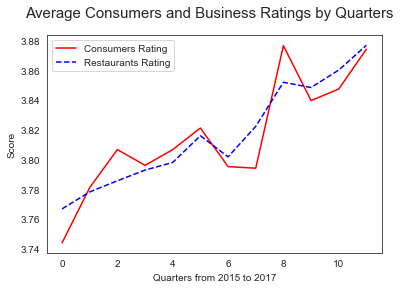

In [96]:
plt.plot(aggdate.index, aggdate["y2"], '-r', label='Consumers Rating')
plt.plot(aggdate.index, aggdate["star_bus"], '--b', label='Restaurants Rating')
plt.suptitle("Average Consumers and Business Ratings by Quarters", fontsize=15)
plt.legend()
plt.xlabel("Quarters from 2015 to 2017")
plt.ylabel("Score")
plt.savefig("Average Consumers and Business Ratings by Quarters.png")

##### Detrending

Problem: average rating increases every year. One possible reason: restaurants give incentives to customers who give high ratings (then the ratings and reviews might be biased)

Across different years, the means of the scores seem to be growing. Thus the scores is not stationary. We need to de-trend this variable for the analysis. This could be done by calculating the average growth rate in scores across all 9 quarters and dividing each score by (1 + avg_growth_rate) ** (quarter-0).

This method is adopted from detrending the inflation effect in macroeconomics.

In [104]:
avg_score_by_quarter =  agg.groupby(["quarter"])[["y2"]].mean().values

# Calculate the average growth rate in salaries across all quarters
avg_growth_rate = ((avg_score_by_quarter[1:] - avg_score_by_quarter[:-1]) / avg_score_by_quarter[:-1]).mean()
#avg_growth_rate = 2.73

# Divide each salary by (1 + avg_growth_rate) ** (grad_year - baseline)
agg['rate'] = (1 + avg_growth_rate) ** (agg.quarter-0)
agg['y2_new'] = agg['y2']/agg['rate']
agg['star_bus_new'] = agg['star_bus']/agg['rate']

# Replace with new adjusted numbers
X['star_bus'] = agg['star_bus_new']
X['y2'] = agg['y2_new']

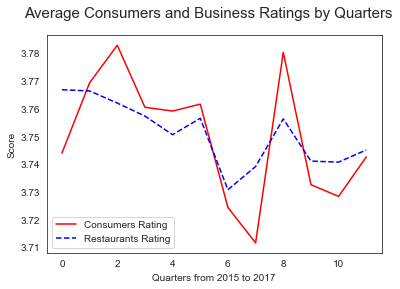

In [106]:
aggdate = agg.groupby(["quarter"])[["y2_new", "star_bus_new"]].mean()
plt.plot(aggdate.index, aggdate["y2_new"], '-r', label='Consumers Rating')
plt.plot(aggdate.index, aggdate["star_bus_new"], '--b', label='Restaurants Rating')
plt.suptitle("Average Consumers and Business Ratings by Quarters", fontsize=15)
plt.legend()
plt.xlabel("Quarters from 2015 to 2017")
plt.ylabel("Score")
plt.savefig("Average Consumers and Business Ratings by Quarters.png")

In [109]:
np.corrcoef(X["star_bus"], X["cts_bus"])[0,1]

0.13972262480063175

In [112]:
np.corrcoef(X["star_bus"], y)[0,1]

0.40080014271491926

In [113]:
np.corrcoef(X["cts_bus"],y)[0,1]

0.049121058473458136

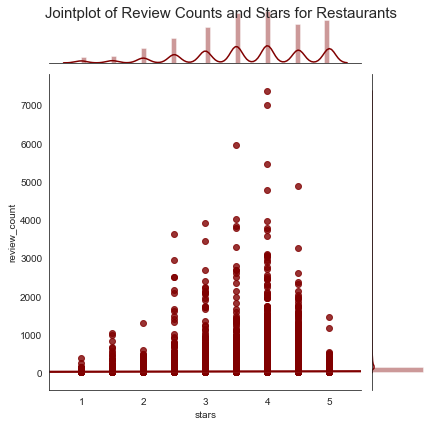

In [114]:
# hexagonal bins
sns.jointplot(bus['stars'], bus['review_count'],kind="reg", color="maroon")
plt.suptitle("Jointplot of Review Counts and Stars for Restaurants", fontsize=15)
plt.savefig("stars_review.png")

In [118]:
# Rescale y2 to 0-100 scale again
# b. Normalization
X['normy'] = (X['y2'] - np.mean(X['y2']))/np.std(X['y2'])

# c. Rescale to 0-100 
X['y'] = ((100 - 0) / (max(X['normy'] ) - min(X['normy'] ))) * (X['normy'] - min(X['normy'])) + 0 

##### Gender

In [120]:
guess = gender.Detector()
agg["guess"] = [guess.get_gender(i) for i in agg["name_y"]]
X['gender'] = np.where(agg["guess"].str.contains("female"), 1, 0)
print("Ratio of females inferred from the names:",
      round(X['gender'].sum()/X.shape[0], 2))

Ratio of females inferred from the names: 0.44


Text(0.5, 0.98, 'Histogram of Satisfaction Scores by Gender')

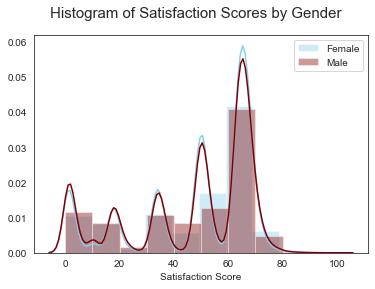

In [121]:
sns.distplot(X[X['gender']==1]['y'], bins=10,  color="skyblue", label="Female")
sns.distplot(X[X['gender']==0]['y'], bins=10, color="maroon", label="Male")
plt.legend()
plt.xlabel('Satisfaction Score')
plt.suptitle('Histogram of Satisfaction Scores by Gender', fontsize=15)
#plt.savefig('Histogram of Satisfaction Scores by Gender.png')

In [122]:
# dataframe for plot
XG = X.groupby('gender').mean().round(2)
XG.head()

,cts_bus,star_bus,y2,normy,y
gender,,,,,
0,883.43,3.74,3.72,-0.02,47.08
1,903.01,3.76,3.79,0.02,48.01


In [34]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

#render_mpl_table(XG, header_columns=0, col_width=2.0)
#plt.savefig('gendertable.png')

##### Weekend 

In [125]:
# Monday 0 to Sunday 6
# Hypothesis: reviews written on Friday, Saturday, and Sunday are different from the ones written during weekdays
agg["dayofweek"] = agg["DATE"].dt.dayofweek
agg["dayofweek"].head()

0    0
1    5
2    5
3    0
4    2
Name: dayofweek, dtype: int64

In [126]:
def weekend(df):
    
    if df["dayofweek"]==4:
        return 1
    elif df["dayofweek"]==5:
        return 1
    elif df["dayofweek"]==6:
        return 1   
    else:
        return 0

In [127]:
# 0: 457519; 1: 338069
# Percentage 0f 1: 42.49%
X["weekend"] = agg.apply(weekend, axis=1)
X["weekend"].value_counts()

0    266320
1    216297
Name: weekend, dtype: int64

In [128]:
X.head()

,cts_bus,star_bus,y2,normy,y,gender,weekend
0,13,3.900554,4.225601,0.282242,53.861259,1,0
1,13,3.925182,5.262096,0.895892,67.719390,0,1
2,13,3.949964,0.246873,-2.073337,0.664964,1,1
3,13,3.925182,1.471943,-1.348043,17.044371,0,0
4,13,3.962414,0.279832,-2.053824,1.105628,0,0


In [129]:
stats.describe(X[X["weekend"]==0]['y'])

DescribeResult(nobs=266320, minmax=(0.0, 100.0), mean=47.56661976455047, variance=500.25481060352666, skewness=-0.8917597831238238, kurtosis=-0.48951395712408985)

In [130]:
stats.describe(X[X["weekend"]==1]['y'])

DescribeResult(nobs=216297, minmax=(0.030069659778084998, 97.38117256882376), mean=47.389785018615946, variance=521.9795058304924, skewness=-0.8812164191957148, kurtosis=-0.5680509298119563)

Text(0.5, 0.98, 'Histogram of Satisfaction Scores by Weekend/Weekday')

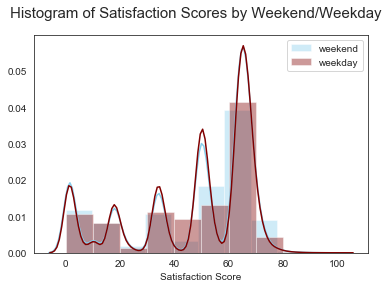

In [131]:
sns.distplot(X[X['weekend']==1]['y'], bins=10, color="skyblue", label="weekend")
sns.distplot(X[X['weekend']==0]['y'], bins=10, color="maroon", label="weekday")
plt.legend()
plt.xlabel('Satisfaction Score')
plt.suptitle('Histogram of Satisfaction Scores by Weekend/Weekday', fontsize=15)
#plt.savefig('Histogram of Satisfaction Scores by WeekendWeekday.png')

##### With group

In [133]:
keywords = ["we", "our", "us", "daughter", "son", "children", "family",
           "friends", "friend", "guests", "buddy", "colleagues", "wife", "husband", "party"]

def withgroup(df):
    
    vocas = [i.lower() for i in df['text'].split()]
    
    for key in keywords:         
        if key in vocas:
            return 1  
    return 0
        
# create new column for food categories
X["group"] = agg.apply(withgroup, axis=1)

In [134]:
X["group"].value_counts()

0    242655
1    239962
Name: group, dtype: int64

In [135]:
stats.describe(X[X["group"]==0]['y'])

DescribeResult(nobs=242655, minmax=(0.0, 100.0), mean=48.51740306121596, variance=493.2602189006325, skewness=-0.9675061923723042, kurtosis=-0.33693895801044116)

In [136]:
stats.describe(X[X["group"]==1]['y'])

DescribeResult(nobs=239962, minmax=(0.030069659778084998, 97.44833274012053), mean=46.445770855582516, variance=524.7678432513867, skewness=-0.8098678101162553, kurtosis=-0.6884107540039688)

Text(0.5, 0.98, 'Histogram of Satisfaction Scores by (Not) With Groups')

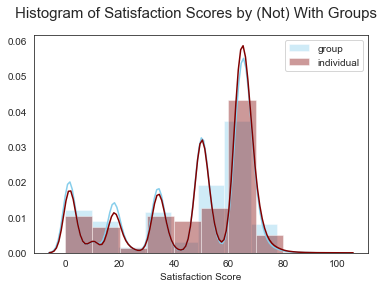

In [137]:
sns.distplot(X[X['group']==1]['y'], bins=10, color="skyblue", label="group")
sns.distplot(X[X['group']==0]['y'], bins=10, color="maroon", label="individual")
plt.legend()
plt.xlabel('Satisfaction Score')
plt.suptitle('Histogram of Satisfaction Scores by (Not) With Groups', fontsize=15)
#plt.savefig('Histogram of Satisfaction Scores by (Not) With Groups.png')

##### Food Categories

In [141]:
Ameri = ["American (New)", "American (Traditional)", "Burgers", "Chicken Wings",
        "Fast Food", "Hot Dogs", "Salad", "Sandwiches", "Barbeque"
         "Smokehouse", "Pizza", "Cheesesteaks", "Cafeteria"]
Europ = ["Italian", "French", "British", "Hungarian", "lombian","Portuguese", "German",
         "Russian", "Spanish", "Ukrainian", "Fish & Chips", 
         "Greek", "Irish", "Modern European", "Polish", "Bulgarian", "Armenian"]
SouAM = ["Mexican", "Argentine", "Cajun", "Caribbean", "Peruvian",
         "Honduran", "Salvadoran", "Venezuelan", "Puerto Rican", "Tex-Mex", 
         "New Mexican Cuisine", "Nicaraguan", "Tacos", "Latin American"]
Asian = ["Thai", "Japanese", "Fusion", "Korean",
          "Filipino","Hawaiian", "Curry", "Asian", "Pan Asian",
         "Soba", "Vietnamese", "Singaporean", "Mongolian", 
         "Guamanian", "Himalayan/Nepalese", "Malaysian",
         "Middle Eastern", "Sushi Bars", "Hong Kong Style Cafe", "Bubble Tea"]
Indian = ['Indian']
Chinese = ["Chinese",  "Taiwanese", "Cantonese", "Shanghainese", "Szechuan",
          "Dim Sum", "Ramen", "Hot Pot"]
MidEas = ["Mediterranean","Kebab", "Pakistani", "Persian/Iranian", "Falafel", "Lebanese"]
Drinks = ["Beer", "Coffee", "Wine Bars", "Pubs",  "Wineries", 
          "Wine & Spirits", "Tea Rooms", "Irish Pub", "Juice Bars & Smoothies", "Bars"]

def fooddummy(df, keywords):
    for key in keywords: 
        if key in df['categories']:
            return 1     
    return 0

# Full List (Too slow to run through)
FoodCate = ["Ameri", "Europ", "SouAM", "Asian", 
            "Indian", "Chinese", "MidEas", "Drinks"]
FoodCateKeys = [Ameri, Europ, SouAM, Asian, 
                Indian, Chinese, MidEas, Drinks]

#Simplified List (Just pick two most unique categories)
#FoodCate = ["Asian", "Drinks"]
#FoodCateKeys = [Asian, Drinks]

#c reate new column for food categories
for index, name in enumerate(FoodCate):
    X[name] = agg.apply(fooddummy, args=(FoodCateKeys[index],), axis=1)

In [142]:
def category(df):
    
    if df['Ameri']==1:
        return 'American'
    elif df['Europ']==1:
        return 'Europe'
    elif df['SouAM']==1:
        return 'South American'
    elif df['Asian']==1:
        return 'Asian'
    elif df['Indian']==1:
        return 'Indian'
    elif df['Chinese']==1:
        return 'Chinese'
    elif df['MidEas']==1:
        return 'Middle East'
    elif df['Drinks']==1:
        return 'Bars & Drinks'
    else:
        return 'Others'
    
X['category'] = X.apply(category, axis = 1)

In [46]:
X['category'].value_counts()

American          379859
Asian             173051
Europe             81179
Others             69998
South American     60540
Bars & Drinks      27944
Middle East         3017
Name: category, dtype: int64

###### Overlapping densities visualization

https://seaborn.pydata.org/generated/seaborn.kdeplot.html

https://seaborn.pydata.org/examples/kde_ridgeplot.html    

Text(0.5, 8.959999999999866, 'score')

<Figure size 576x720 with 0 Axes>

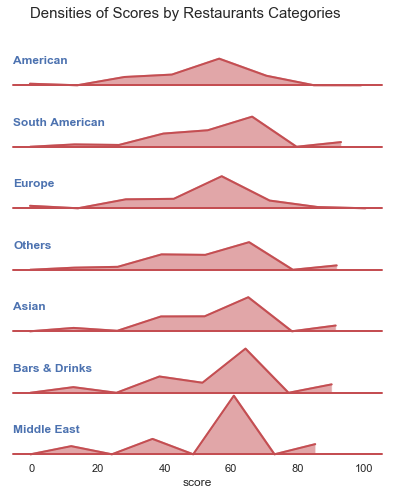

In [50]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize = (8,10))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(X, row="category", hue="category", aspect=6, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "y", clip_on=False, shade=True, color="r", gridsize=8, alpha=0.5, lw=2, bw=.2)
g.map(sns.kdeplot, "y", clip_on=False, color="r", gridsize=8,  lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, color="r", clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .4, label, fontweight="bold", color="b",
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "y")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('Densities of Scores by Restaurants Categories', fontsize=15)
plt.xlabel('score')
#plt.savefig("DensitiesCategories.png")

In [48]:
#Coorelation Matrix Heatmap

#plt.matshow(X.corr())
#plt.xticks(range(len(X.columns)), X.columns)
#plt.yticks(range(len(X.columns)), X.columns)
#plt.colorbar()

### Machine Learning

The ML algorithm will predict our satisfaction (utility) from dining at a particular restaurant. The predicted score will be used to rank the filtered options.

#### Preview data

In [51]:
X = X.drop(["y", "category"], axis=1)
X.head()

,cts_bus,star_bus,gender,weekend,group,Ameri,Europ,SouAM,Asian,MidEas,Drinks
0,13,4.0,1,0,0,1,0,0,0,0,1
1,13,4.0,0,1,1,1,0,0,0,0,1
2,13,4.0,1,1,1,1,0,0,0,0,1
3,13,4.0,0,0,1,1,0,0,0,0,1
4,13,4.0,0,0,0,1,0,0,0,0,1


In [49]:
y[:10]

0    51.171588
1    63.924229
2     0.569042
3    16.059617
4     0.971621
5    48.303911
6    59.433228
7    47.040768
8    59.433228
9    59.433228
Name: y, dtype: float64

In [52]:
#make sure the rows number match!
(X.shape,y.shape)

((795588, 11), (795588,))

#### Predictive Models

##### Feature importance using Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor
rfc= RandomForestRegressor(n_estimators=100,n_jobs=4).fit(X, y)
for name,score in zip(X.columns,rfc.feature_importances_):
    print(name,score)

cts_bus 0.16534131210167702
star_bus 0.7090972852750612
gender 0.020648427832941484
weekend 0.033040524879725655
group 0.017751471135395686
Ameri 0.012062897641024204
Europ 0.007286078036036789
SouAM 0.010035831794529968
Asian 0.011018035175814572
MidEas 0.003078170308981855
Drinks 0.010639965818811749


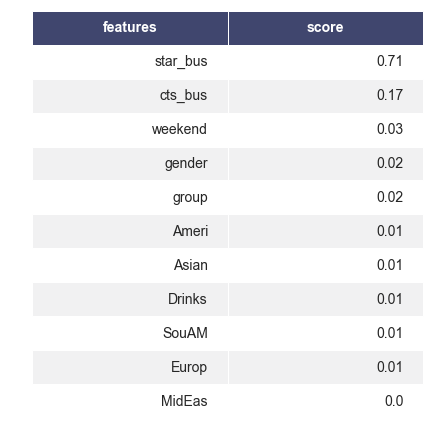

In [56]:
imp = pd.DataFrame({"features":X.columns, "score": rfc.feature_importances_})
imp = imp.sort_values(by='score', ascending=False)
imp = imp.round(2)
render_mpl_table(imp, header_columns=0, col_width=3.5)
plt.savefig('importance.png')

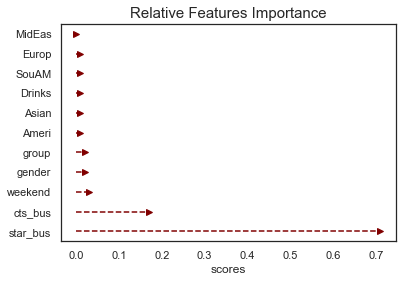

In [111]:
plt.hlines(y=imp["features"], xmin=0, xmax=imp['score'],
           linestyles ='dashed', color='maroon')

plt.plot(imp['score'], imp["features"], ">", color='maroon')
 
plt.yticks(imp["features"])
plt.title("Relative Features Importance", loc='center', fontsize=15)
plt.xlabel('scores')
#plt.savefig("Relative Features Importance.png")

Random Forest measures the relative importance of each predictor by counting the number of associated training samples in the 500 trees. The five most importance features are ...

The food categories are not important at all for predicting customer satisfaction. So we delete them from machine learning models.

In [58]:
X=X.drop(["Ameri", "Europ", "SouAM", "Asian", "MidEas", "Drinks"], axis=1)
X.head()

,cts_bus,star_bus,gender,weekend,group
0,13,4.0,1,0,0
1,13,4.0,0,1,1
2,13,4.0,1,1,1
3,13,4.0,0,0,1
4,13,4.0,0,0,0


##### Training and testing sets

In [56]:
#Divide the data into training and test set, with ratio 3:1 (test=25%).
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

 experiment with only most important features
X_train, X_test, y_train, y_test = train_test_split(X[["sentiment", "stars_x"]] , y, random_state=0)

##### Linear Regression

In [57]:
lin = LinearRegression().fit(X_train, y_train)

In [58]:
linkf = cross_val_score(lin, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-linkf.mean(),2))
print("Standard deviation:",round(linkf.std(),2))

Mean: 358.43
Standard deviation: 1.06


In [91]:
linfull = LinearRegression().fit(X, y)
linkffull = cross_val_score(linfull, X, y, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-linkffull.mean(),2))
print("Standard deviation:",round(linkffull.std(),2))

Mean: 358.5
Standard deviation: 7.94


In [62]:
lin.coef_

array([ 0.75585888, 56.16279381,  0.76078494, -0.18947821, -2.50833473])

In [59]:
lin.intercept_

6.555260234425063

In [60]:
lin_full = LinearRegression().fit(X, y)

In [61]:
import statsmodels.api as sm
X2=sm.add_constant(X_train)
model = sm.OLS(y_train, X2).fit()
#predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                 1.014e+04
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        15:04:55   Log-Likelihood:            -2.6014e+06
No. Observations:              596691   AIC:                         5.203e+06
Df Residuals:                  596679   BIC:                         5.203e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5553      0.136     48.330      0.0

##### Lasso Regression


In [62]:
las = Lasso().fit(X_train, y_train)

In [69]:
alpha_grid = {"alpha":np.linspace(0,5,200)}
grid_search2 = GridSearchCV(las, param_grid=alpha_grid, n_jobs=4, cv=5,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)
print('GridBestEstimatorLasso=', grid_search2.best_estimator_)
print('GridBestParamsLasso=', grid_search2.best_params_)
print('GridBestScoreLasso=', -grid_search2.best_score_)

GridBestEstimatorLasso= Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
GridBestParamsLasso= {'alpha': 0.0}
GridBestScoreLasso= 358.4295280251278


In [70]:
las = Lasso(alpha=grid_search2.best_params_['alpha']).fit(X_train, y_train)
laskf = cross_val_score(las, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-laskf.mean(),2))
print("Standard deviation:",round(laskf.std(),2))

Mean: 358.43
Standard deviation: 1.06


In [71]:
las.coef_

array([ 8.20274356e-01,  5.58328182e+01,  7.66031335e-01, -1.86186706e-01,
       -2.53465278e+00, -6.18930388e-01,  3.20490485e-01, -5.93524694e-02,
        8.93589861e-02,  8.31330807e-03,  1.01268814e-01])

##### Ridge Regression

In [72]:
rid = Ridge(alpha=1).fit(X_train, y_train)

In [73]:
alpha_grid = {"alpha":np.linspace(1,50,1000)}
grid_search1 = GridSearchCV(rid, param_grid=alpha_grid, n_jobs=4, cv=5,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)
print('GridBestEstimatorRidge=', grid_search1.best_estimator_)
print('GridBestParamsRidge', grid_search1.best_params_)
print('GridBestScoreRidge=', -grid_search1.best_score_)

GridBestEstimatorRidge= Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
GridBestParamsRidge {'alpha': 1.0}
GridBestScoreRidge= 358.4295284663578


In [74]:
rid = Ridge(alpha=grid_search1.best_params_['alpha']).fit(X_train, y_train)
ridkf = cross_val_score(rid, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Mean:",round(-ridkf.mean(),2))
print("Standard deviation:",round(ridkf.std(),2))

Mean: 358.43
Standard deviation: 1.06


##### Bayesian Ridge Regression

https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html#sphx-glr-auto-examples-linear-model-plot-bayesian-ridge-py

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.27.9072&rep=rep1&type=pdf

In [75]:
bay = BayesianRidge().fit(X_train, y_train)
baykf=cross_val_score(bay, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-baykf.mean(),2))
print("Standard deviation:",round(baykf.std(),2))

Mean: 358.43
Standard deviation: 1.06


##### Decision Tree

In [76]:
tree = DecisionTreeRegressor().fit(X_train, y_train)

In [77]:
param_dist_tree = {'max_depth': sp_randint(2, 100),
               'min_samples_split': sp_randint(2, 100),
               'min_samples_leaf': sp_randint(2, 100)}

random_search_tree = RandomizedSearchCV(tree, param_distributions=param_dist_tree,
                       n_jobs=4, cv=5, random_state=25,
                       scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorTree=', random_search_tree.best_estimator_)
print('RandBestParamsTree=', random_search_tree.best_params_)
print('RandBestScoreTree=', random_search_tree.best_score_)

RandBestEstimatorTree= DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=64,
           min_samples_split=92, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
RandBestParamsTree= {'max_depth': 6, 'min_samples_leaf': 64, 'min_samples_split': 92}
RandBestScoreTree= -357.7829235913748


In [78]:
bptree=random_search_tree.best_params_
tree = DecisionTreeRegressor(max_depth = bptree['max_depth'],
                             min_samples_leaf = bptree['min_samples_leaf'],
                             min_samples_split = bptree['min_samples_split']).fit(X_train, y_train)

In [79]:
treekf=cross_val_score(tree, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-treekf.mean(),2))
print("Standard deviation:",round(treekf.std(),2))

Mean: 357.78
Standard deviation: 1.04


##### Random Forest

In [80]:
rfr = RandomForestRegressor().fit(X_train, y_train)

In [81]:
param_dist_rfr = {'n_estimators':sp_randint(10, 200),
               'max_depth': sp_randint(5, 20),
               'min_samples_split': sp_randint(0, 20),
               'min_samples_leaf': sp_randint(0, 20),
               'max_features':sp_randint(1,5)}

random_search_rfr = RandomizedSearchCV(rfr, param_distributions=param_dist_rfr,
                        n_jobs=4, cv=5, random_state=25,
                       scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorrfr=', random_search_rfr.best_estimator_)
print('RandBestParamsrfr=', random_search_rfr.best_params_)
print('RandBestScorerfr=', -random_search_rfr.best_score_)

RandBestEstimatorrfr= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=17,
           min_samples_split=18, min_weight_fraction_leaf=0.0,
           n_estimators=102, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
RandBestParamsrfr= {'max_depth': 11, 'max_features': 4, 'min_samples_leaf': 17, 'min_samples_split': 18, 'n_estimators': 102}
RandBestScorerfr= 356.97362798750225


In [82]:
bprfr=random_search_rfr.best_params_
rfr = RandomForestRegressor(max_depth = bprfr['max_depth'],
                             max_features = bprfr['max_features'],
                             min_samples_leaf = bprfr['min_samples_leaf'],
                             min_samples_split = bprfr['min_samples_split']).fit(X_train, y_train)

In [83]:
rfrkf=cross_val_score(rfr, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-rfrkf.mean(),2))
print("Standard deviation:",round(rfrkf.std(),2))

Mean: 357.28
Standard deviation: 0.92


##### Gradient Boosting

In [85]:
gra = GradientBoostingRegressor(random_state=10, n_estimators=50,).fit(X_train,y_train) 
grakf = cross_val_score(gra, X_train, y_train, cv=5, 
                        scoring = "neg_mean_squared_error")
print("Mean:",round(-grakf.mean(),2))
print("Standard deviation:",round(grakf.std(),2))

Mean: 357.81
Standard deviation: 1.04


In [86]:
param_dist_gra = {'max_depth': sp_randint(1, 5),
                  'n_estimators': sp_randint(20,100),
                   'learning_rate': np.linspace(0.2, 0.8, 10),
                   'alpha': np.linspace(0.2, 0.9, 10) }

random_search_gra = RandomizedSearchCV(estimator = GradientBoostingRegressor(),
                    param_distributions = param_dist_gra, n_jobs=4,iid=False, 
                    cv=5, random_state=25, scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorxgb=', random_search_gra.best_estimator_)
print('RandBestParamsxgb=', random_search_gra.best_params_)
print('RandBestScorexgb=', -random_search_gra.best_score_)

RandBestEstimatorxgb= GradientBoostingRegressor(alpha=0.2777777777777778, criterion='friedman_mse',
             init=None, learning_rate=0.6000000000000001, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=68,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
RandBestParamsxgb= {'alpha': 0.2777777777777778, 'learning_rate': 0.6000000000000001, 'max_depth': 4, 'n_estimators': 68}
RandBestScorexgb= 356.6571864381902


In [87]:
bpgra = random_search_gra.best_params_
gra = GradientBoostingRegressor(alpha=bpgra['alpha'],
                    learning_rate=bpgra['learning_rate'],
                    max_depth=bpgra['max_depth'],
                    n_estimators=bpgra['n_estimators']).fit(X_train, y_train)

In [88]:
grakf=cross_val_score(gra, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-grakf.mean(),2))
print("Standard deviation:", round(grakf.std(),2))

Mean: 356.66
Standard deviation: 1.1


##### Multi-layer Perceptron

In [89]:
from sklearn.neural_network import MLPRegressor
mlp= MLPRegressor(activation='tanh', solver='lbfgs', alpha=0.1).fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
param_dist_mlp = {'hidden_layer_sizes':sp_randint(10, 100),
               'activation':["logistic", "relu"],
               'alpha': sp_uniform(0.1, 10.0)}

random_search_mlp = RandomizedSearchCV(mlp, param_distributions = param_dist_mlp,
                       n_jobs=4, cv=5, random_state=25,
                       scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimator5=', random_search_mlp.best_estimator_)
print('RandBestParams5=', random_search_mlp.best_params_)
print('RandBestScore5=', -random_search_mlp.best_score_)

In [ ]:
bpmlp = random_search_mlp.best_params_
mlp = MLPRegressor(hidden_layer_sizes = bpmlp['hidden_layer_sizes'],
                           activation = bpmlp['activation'],
                                alpha = bpmlp['alpha']).fit(X_train, y_train)

In [ ]:
mlpkf = cross_val_score(mlp, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-mlpkf.mean(),2))
print("Standard deviation:", round(mlpkf.std(),2))

##### Elastic Net

In [ ]:
ela = ElasticNet(alpha=1,l1_ratio=0.5).fit(X_train, y_train)

In [ ]:
alpha_ratio_grid = {"alpha": np.linspace(0,1,5),
                  "l1_ratio": np.linspace(0,1,5)}

grid_search3 = RandomizedSearchCV(ela, param_distributions = alpha_ratio_grid, 
                       n_jobs = 4, cv = 5, random_state = 25,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)

print('GridBestEstimator=', grid_search3.best_estimator_)
print('GridBestParams=', grid_search3.best_params_)
print('GridBestScore=', -grid_search3.best_score_)

In [ ]:
ela = ElasticNet(alpha=grid_search3.best_params_['alpha'],
                l1_ratio=grid_search3.best_params_['l1_ratio']).fit(X_train, y_train)

elakf = cross_val_score(ela, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Mean:",round(-elakf.mean(),2))
print("Standard deviation:",round(elakf.std(),2))

#### Model Comparsion

#### Note:
Models that we didn't report as they produce higher MSE:
KNN, XGboost, Adaboost, SVM

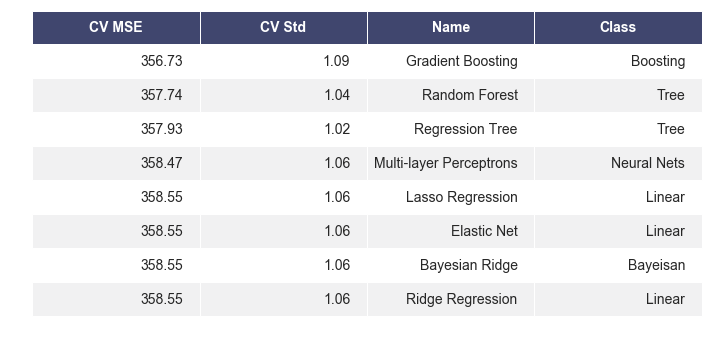

In [124]:
results = pd.DataFrame({'CV MSE':[-treekf.mean(), -rfrkf.mean(), -grakf.mean(),
                                -laskf.mean(), -ridkf.mean(), -baykf.mean(), -elakf.mean(), -mlpkf.mean()],
                      
                      'CV Std':[treekf.std(), rfrkf.std(), grakf.std(), 
                                laskf.std(), ridkf.std(), baykf.std(), elakf.std(), mlpkf.std()], 
                      
                     'Name':["Regression Tree","Random Forest","Gradient Boosting", 
                             "Lasso Regression", "Ridge Regression", "Bayesian Ridge", 
                            "Elastic Net",  "Multi-layer Perceptrons"],
                     
                     'Class':['Tree', 'Tree', 'Boosting', 'Linear', 'Linear', 
                              'Bayeisan', 'Linear', 'Neural Nets'],})
                     
results = results.sort_values(by=['CV MSE']).round(2)
render_mpl_table(results, header_columns=0, col_width=3.0)
plt.savefig('regres.png')

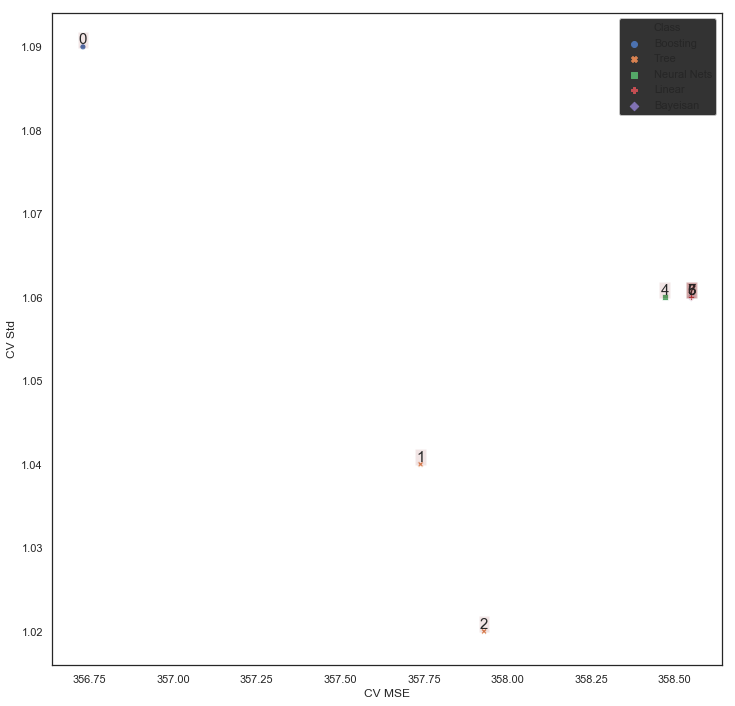

In [125]:
plt.figure(figsize = (12,12))

ax=sns.scatterplot(x='CV MSE', y='CV Std', hue='Class', style='Class',
                   data=results)
#plt.legend()
#ax.set_xlim(min(results['CV MSE']), max(results['CV MSE']))
#ax.set_ylim(min(results['CV Std']), max(results['CV Std']), 1000)
for line in range(0,results.shape[0]):
     ax.text(results['CV MSE'][line], results['CV Std'][line], 
             results.index[line], horizontalalignment='center', 
             verticalalignment='bottom',
             bbox=dict(facecolor='maroon', alpha=0.1, pad=1), fontsize=15)
plt.savefig('Model Scatter.png')

In [126]:
results

,CV MSE,CV Std,Name,Class
2,356.73,1.09,Gradient Boosting,Boosting
1,357.74,1.04,Random Forest,Tree
0,357.93,1.02,Regression Tree,Tree
7,358.47,1.06,Multi-layer Perceptrons,Neural Nets
3,358.55,1.06,Lasso Regression,Linear
6,358.55,1.06,Elastic Net,Linear
5,358.55,1.06,Bayesian Ridge,Bayeisan
4,358.55,1.06,Ridge Regression,Linear


<Figure size 600x600 with 0 Axes>

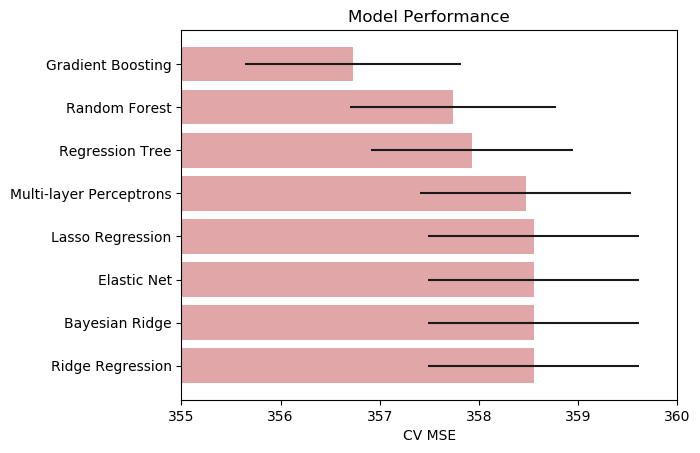

In [176]:
#plt.rcdefaults()
plt.figure(figsize = (6,6))

fig, ax = plt.subplots()

ax.barh(results['Name'], results['CV MSE'], xerr=results['CV Std'],
        align='center', color='r', alpha=0.5, ls=":")
ax.set_xlim([355,360])
#ax.set_yticklabels(results['Name'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('CV MSE')
ax.set_title('Model Performance')
plt.savefig('Performance.png')

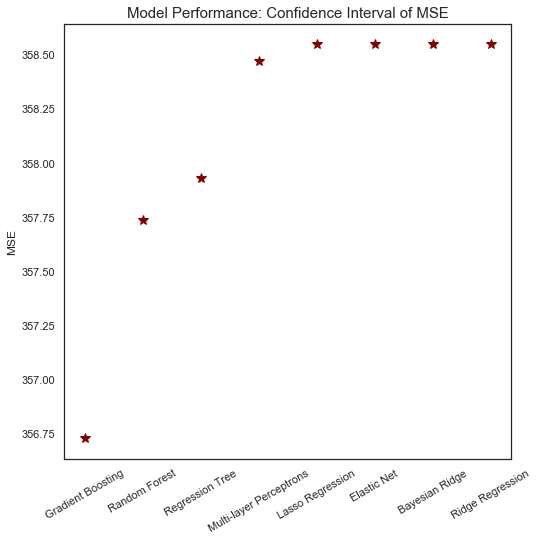

In [127]:
plt.figure(figsize = (8,8))

ind = results['Name']
mse = results['CV MSE']
err = results['CV Std']*1.96/np.sqrt(len(X))

plt.errorbar(ind, mse, err, linestyle='None', marker='*',  mfc='maroon',
         mec='maroon', ms=10, mew=1, ls=':')
plt.xticks(rotation=30)
plt.ylabel('MSE')
plt.title('Model Performance: Confidence Interval of MSE', fontsize=15)
plt.savefig('Model Performance.png')

#### Performance on test set

In [180]:
mean_squared_error(rfr.predict(X_test), y_test)

357.7008311464775

In [96]:
mean_squared_error(gra.predict(X_test), y_test)

356.56518122288804

In [97]:
mean_squared_error(rfr.predict(X_test), y_test)

357.7008311464775

In [178]:
mean_squared_error(lin.predict(X_test), y_test)

358.22110938924834

In [105]:
end = time.time()
print("Minutes to run",(end-start)/60)

Minutes to run 93.93365021149317


#### Visualization

In [177]:
np.sqrt(358)

18.920887928424502

In [159]:
X.columns

Index(['cts_bus', 'star_bus', 'gender', 'weekend', 'group'], dtype='object')

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
tree_viz = export_graphviz(
    tree,
    out_file="tree.png",
    feature_names=['cts_bus', 'star_bus', 'gender', 'weekend', 'group'],
    class_names=y,
    rounded=True,
    filled=True,
    precision=1
)

graph = graphviz.Source(tree_viz)
graph.render('tree_viz')
#graph